# S-Bert Pipeline

In [1]:
from typing import List, Union, Tuple

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from arqmath_code.Entities.Post import Question, Answer
from arqmath_code.topic_file_reader import Topic

## Simple S-Bert Pipeline

In [2]:
from src import init_data
topic_reader, data_reader = init_data(task=1)

reading users
reading comments
reading votes
reading post links
reading posts


In [13]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained("tbs17/MathBERT", output_hidden_states=True)
model = BertModel.from_pretrained("tbs17/MathBERT")
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')["input_ids"]
print(encoded_input.size())
print(tokenizer.decode(encoded_input[0]))
output = model(encoded_input)
output

Some weights of the model checkpoint at tbs17/MathBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([1, 12])
[CLS] replace me by any text you'd like. [SEP]


BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-2.2231, -1.3936,  0.5216,  ..., -1.4718, -0.6842,  0.3158],
         [-0.2880, -1.4961,  1.6760,  ..., -0.4412, -1.4036,  0.4086],
         [-0.4111, -1.3079,  0.4837,  ..., -2.2450, -1.1092,  0.1752],
         ...,
         [-1.8459, -2.0335, -0.6122,  ..., -0.8721, -0.5455, -0.2235],
         [-0.1422,  1.6059, -0.3686,  ..., -0.8420, -0.2116, -0.2278],
         [-0.6735,  1.3250,  0.5233,  ..., -0.5570,  0.3374,  0.9640]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-1.1742e-01, -6.5391e-01,  8.7016e-01, -5.1339e-01,  1.7087e-01,
         -5.5788e-01,  4.2671e-01,  6.1906e-01,  2.7943e-01, -3.5963e-01,
          5.8281e-01, -4.7622e-01,  1.3670e-01,  1.6635e-01, -5.8218e-01,
          1.1004e-01, -3.2577e-01, -4.3149e-01,  6.6923e-01, -2.8001e-01,
          8.2339e-01, -7.1742e-01,  4.8106e-01,  3.1566e-01, -6.8671e-01,
          5.8721e-01,  7.0809e-01, -4.5651e-01, -7.0852e-01,  6.494

In [14]:
print(output.last_hidden_state.size())
output.last_hidden_state[0,0]

torch.Size([1, 12, 768])


tensor([-2.2231e+00, -1.3936e+00,  5.2164e-01, -1.1962e+00, -1.1041e+00,
        -1.0853e+00, -6.9400e-01, -9.0696e-01, -1.2116e+00, -3.6992e-01,
        -4.5352e-01,  9.4478e-01, -2.9552e-01,  6.9703e-01, -4.0970e+00,
        -1.5467e-01, -1.3264e+00,  1.5981e+00,  7.3125e-03,  1.6195e+00,
        -9.8833e-01,  4.4628e-01,  5.2678e-01,  6.0169e-01, -3.9136e-02,
         8.1383e-01,  3.4131e+00, -6.0480e-01,  7.8776e-01, -2.1514e-01,
         5.3082e-01,  2.7428e-01,  6.9694e-01,  1.0118e+00,  6.3361e-01,
        -1.2968e+00,  6.0122e-01, -4.9637e-01,  2.3598e+00, -1.0558e+00,
         7.8685e-01, -2.2897e+00,  1.6963e+00, -1.4375e+00,  6.1504e-01,
         2.6631e+00, -1.1293e+00, -6.4592e-01,  3.5112e-01, -7.0518e-01,
         7.3810e-01,  9.4142e-01, -5.9272e-01, -3.4221e-01,  9.7941e-01,
         1.0112e+00, -3.8004e-02, -9.6038e-01, -1.0530e+00, -1.4943e+00,
         1.8094e+00,  9.8292e-01, -2.0841e+00, -9.8258e-02, -4.6969e-01,
         7.1740e-01, -7.1648e-01, -1.7884e+00, -8.6

In [3]:
from src.mathbert.question_math_bert import QuestionMathBERT
# from src.sbert.question_s_bert import QuestionSBERT
from src.post_processors.top_k_filter import TopKFilter
from arqmath_code.post_reader_record import DataReaderRecord
from src.base.pipeline import Pipeline
from src.post_processors.answer_score_retriever_for_questions import AnswerScoreRetrieverForQuestions

class MathBertPipeline(Pipeline):

    def __init__(self, data_reader: DataReaderRecord):
        super().__init__(data_reader)
        self.sbert = QuestionMathBERT('MathBERT')
#         self.sbert = QuestionSBERT(model_id='tbs17/MathBERT')
        self.answer_score_retriever = AnswerScoreRetrieverForQuestions()
        self.top_k_filter = TopKFilter()

    def run(self, queries: List[Topic]) -> List[Tuple[Topic, Answer, float]]:
        questions: List[Question] = self.data_reader.get_questions()
        ranking: List[
        Tuple[Topic, Union[Question, Answer], float]] = self.sbert(queries=queries, documents=questions)
        ranking = self.answer_score_retriever(queries=queries, ranking=ranking)
        ranking = self.top_k_filter(queries=queries, ranking=ranking)
        return ranking




In [ ]:
from src.runner import Runner
from datetime import datetime

print(datetime.now())
runner = Runner(MathBertPipeline, n=1, data_reader=data_reader, topic_reader=topic_reader)
ranking = runner.run("../results/model_results/MathBert.tsv")
print(datetime.now())
ranking

2022-12-06 12:18:21.048262


Some weights of the model checkpoint at tbs17/MathBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
embedding docs:  11%|█         | 113436/1020585 [1:07:58<8:36:52, 29.25it/s] 

## Evaluation

In [1]:
from arqmath_code.evaluation.task1 import arqmath_to_prime_task1
from arqmath_code.evaluation.task1 import task1_get_results

In [2]:
qrel_dictionary = arqmath_to_prime_task1.read_qrel_to_dictionary("../arqmath_dataset/evaluation/Task 1/Qrel Files/qrel_task1_2022_official.tsv")
arqmath_to_prime_task1.convert_result_files_to_trec(submission_dir="../results/model_results/", qrel_result_dic=qrel_dictionary, prim_dir="../results/ARQmath_prim/", trec_dir="../results/ARQmath_trec/")

In [3]:
number_topics = 78
task1_get_results.get_result(trec_eval_tool="trec_eval", qre_file_path="../arqmath_dataset/evaluation/Task 1/Qrel Files/qrel_task1_2022_official.tsv", prim_result_dir="../results/ARQmath_prim/", evaluation_result_file="../results/results_S-Bert.tsv", number_topics=number_topics)

-----------
['ndcg                  ', 'A.301', '0.3117']
-----------
['ndcg                  ', 'A.302', '0.2712']
-----------
['ndcg                  ', 'A.303', '0.1482']
-----------
['ndcg                  ', 'A.304', '0.3298']
-----------
['ndcg                  ', 'A.305', '0.0986']
-----------
['ndcg                  ', 'A.306', '0.0758']
-----------
['ndcg                  ', 'A.307', '0.2460']
-----------
['ndcg                  ', 'A.308', '0.1113']
-----------
['ndcg                  ', 'A.309', '0.0788']
-----------
['ndcg                  ', 'A.310', '0.1963']
-----------
['ndcg                  ', 'A.312', '0.1317']
-----------
['ndcg                  ', 'A.313', '0.1639']
-----------
['ndcg                  ', 'A.314', '0.3952']
-----------
['ndcg                  ', 'A.315', '0.2060']
-----------
['ndcg                  ', 'A.316', '0.1382']
-----------
['ndcg                  ', 'A.317', '0.1444']
-----------
['ndcg                  ', 'A.318', '0.0750']
-----------
['

## Plot embeddings for more examples

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
q_transformed = pd.DataFrame(pca.fit_transform(q_emb))
d_transformed = pd.DataFrame(pca.fit_transform(d_emb))
print(d_transformed)

              0         1
0     -0.064889 -0.043494
1     -0.045415  0.041631
2     -0.062295  0.007746
3     -0.195928  0.033659
4     -0.089345  0.146417
...         ...       ...
99995 -0.036558 -0.016462
99996 -0.140381  0.059406
99997 -0.237232 -0.008983
99998 -0.272687  0.178042
99999  0.176759  0.208574

[100000 rows x 2 columns]


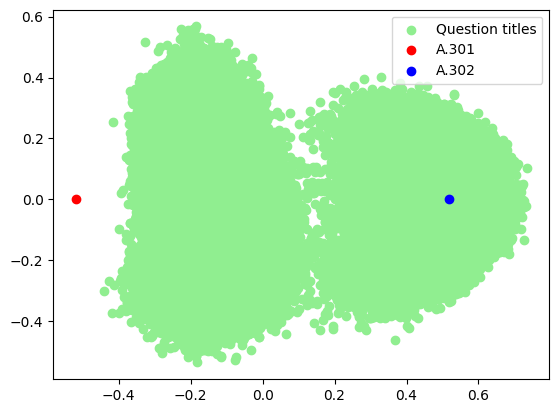

In [10]:
plt.scatter(d_transformed[0], d_transformed[1], label='Question titles', c='lightgreen')
plt.scatter(q_transformed.iloc[0][0], q_transformed.iloc[0][1], label='A.301', c='red')
plt.scatter(q_transformed.iloc[1][0], q_transformed.iloc[1][1], label='A.302', c='blue')
# plt.scatter(transformed.iloc[3][0], transformed.iloc[3][1], label='Class 4', c='lightblue')

plt.legend()
plt.show()

## check embedding loading

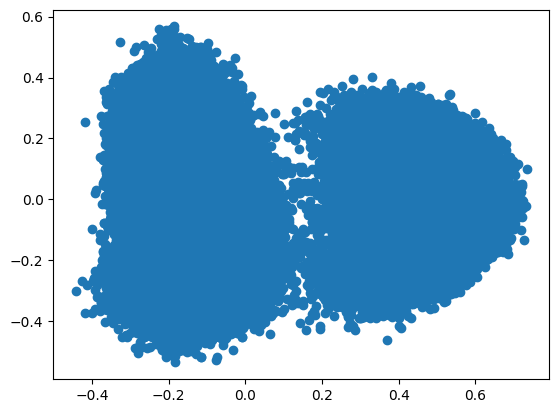

In [14]:
test = np.load('../arqmath_dataset/model_embeddings/test.npy')
test_transformed = pd.DataFrame(pca.fit_transform(test))
plt.scatter(test_transformed[0], test_transformed[1])
plt.show()